In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
df_zhvi = pd.read_csv('../data/processed/zhvi_top100_ts.csv', index_col='Date', parse_dates=True)

In [128]:
def create_sliding_windows(returns_data, raw_data, window_size, prediction_size):
    X = []
    y = []
    for i in range(len(returns_data) - window_size - prediction_size + 1):
        window_returns = returns_data[i:i + window_size].values
        window_raw = raw_data[i:i + window_size].values
        window_combined = np.hstack((window_raw, window_returns))
        X.append(window_combined)
        y.append(returns_data.iloc[i + window_size + prediction_size - 1].values)
    return np.array(X), np.array(y)

# Set parameters
window_size = 12  # 1 year
prediction_size = 12  # 1 year
val_date = '2016-01-01'
split_date = '2020-01-01'

returns_1y = df_zhvi.pct_change(periods=prediction_size)

# Initialize lists to store sequences and labels
X_train, y_train = [], []
returns_1y_train = returns_1y[returns_1y.index < val_date]
df_zhvi_train = df_zhvi[df_zhvi.index < val_date]
# Generate sliding windows for each region
for column in returns_1y.columns:
    region_returns = returns_1y_train[[column]].dropna()
    region_raw = df_zhvi_train[[column]].dropna()[prediction_size:]
    region_X, region_y = create_sliding_windows(region_returns, region_raw, window_size, prediction_size)
    X_train.append(region_X)
    y_train.append(region_y)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")

# Initialize lists to store sequences and labels
X_val, y_val = [], []
returns_1y_val = returns_1y[(returns_1y.index >= val_date) & (returns_1y.index < split_date)]
df_zhvi_val = df_zhvi[(df_zhvi.index >= val_date) & (df_zhvi.index < split_date)]
# Generate sliding windows for each region
for column in returns_1y.columns:
    region_returns = returns_1y_val[[column]].dropna()
    region_raw = df_zhvi_val[[column]].dropna()
    region_X, region_y = create_sliding_windows(region_returns, region_raw, window_size, prediction_size)
    X_val.append(region_X)
    y_val.append(region_y)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

print(f"X val shape: {X_val.shape}")
print(f"y val shape: {y_val.shape}")

# Initialize lists to store sequences and labels
X_test, y_test = [], []
returns_1y_test = returns_1y[returns_1y.index >= split_date]
df_zhvi_test = df_zhvi[df_zhvi.index >= split_date]
# Generate sliding windows for each region
for column in returns_1y.columns:
    region_returns = returns_1y_test[[column]].dropna()
    region_raw = df_zhvi_test[[column]].dropna()
    region_X, region_y = create_sliding_windows(region_returns, region_raw, window_size, prediction_size)
    X_test.append(region_X)
    y_test.append(region_y)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")


X train shape: (15700, 12, 2)
y train shape: (15700, 1)
X val shape: (2500, 12, 2)
y val shape: (2500, 1)
X test shape: (3100, 12, 2)
y test shape: (3100, 1)


In [129]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.fit_transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [130]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
val_dataset = TimeSeriesDataset(X_val_tensor, y_val_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [131]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_size = 2
hidden_size = 50
num_layers = 1
output_size = 1  # Predicting avg returns for next period




In [132]:
# Train the Model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 50
reporting_epochs = 5
model.train()
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # eval the validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    if (epoch+1) % reporting_epochs == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], \
                  Training Loss: {np.mean(train_losses[-reporting_epochs:]):.8f}, \
                  Validation Loss: {np.mean(val_losses[-reporting_epochs:]):.8f}')

Epoch [5/50],                   Training Loss: 0.00458779,                   Validation Loss: 0.02312068
Epoch [10/50],                   Training Loss: 0.00346840,                   Validation Loss: 0.02708112
Epoch [15/50],                   Training Loss: 0.00304593,                   Validation Loss: 0.02501581
Epoch [20/50],                   Training Loss: 0.00291097,                   Validation Loss: 0.02387816
Epoch [25/50],                   Training Loss: 0.00281684,                   Validation Loss: 0.02571842
Epoch [30/50],                   Training Loss: 0.00273419,                   Validation Loss: 0.02668691
Epoch [35/50],                   Training Loss: 0.00266190,                   Validation Loss: 0.02457770
Epoch [40/50],                   Training Loss: 0.00262122,                   Validation Loss: 0.02469640
Epoch [45/50],                   Training Loss: 0.00259623,                   Validation Loss: 0.02523035
Epoch [50/50],                   Training Loss:

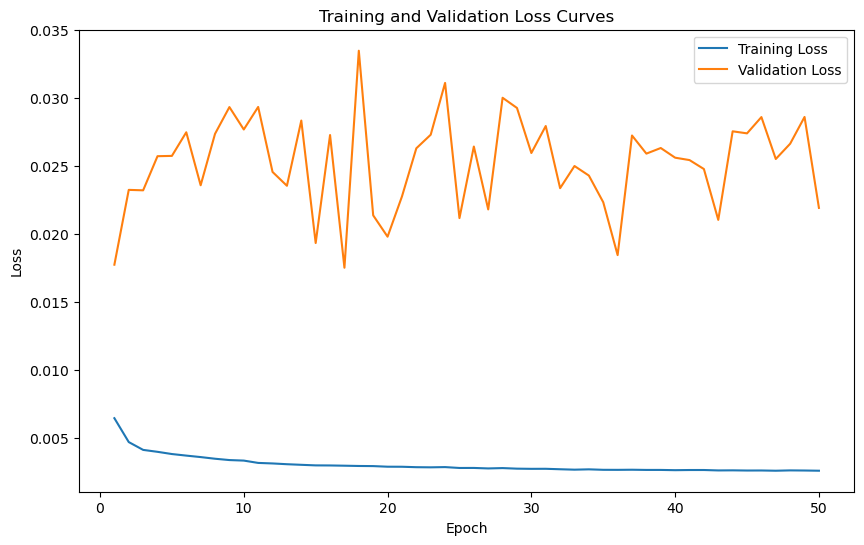

In [133]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [134]:
# Evaluate the LSTM Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)

mse_lstm = mean_squared_error(y_test, y_pred)
mae_lstm = mean_absolute_error(y_test, y_pred)

print(f"LSTM Model - Mean Squared Error: {mse_lstm}")
print(f"LSTM Model - Mean Absolute Error: {mae_lstm}")

# Benchmark Model - Last return from data
y_benchmark_pred = []
for region in X_test:
    y_benchmark_pred.append(region[-1][1])
mse_benchmark = mean_squared_error(y_test, y_benchmark_pred)
mae_benchmark = mean_absolute_error(y_test, y_benchmark_pred)

print(f"Benchmark Model - Mean Squared Error: {mse_benchmark}")
print(f"Benchmark Model - Mean Absolute Error: {mae_benchmark}")

# # Benchmark Model 2- Last month trended
# y_benchmark2_pred = []
# for region in X_test:
#     y_benchmark2_pred.append((region[-1][0] / region[-2][0] - 1) * prediction_size)
# mse_benchmark2 = mean_squared_error(y_test, y_benchmark2_pred)
# mae_benchmark2 = mean_absolute_error(y_test, y_benchmark2_pred)

# print(f"Benchmark Model - Mean Squared Error: {mse_benchmark2}")
# print(f"Benchmark Model - Mean Absolute Error: {mae_benchmark2}")

LSTM Model - Mean Squared Error: 0.03663644792800454
LSTM Model - Mean Absolute Error: 0.1457045994707488
Benchmark Model - Mean Squared Error: 0.011421036808580894
Benchmark Model - Mean Absolute Error: 0.07894846879307237


In [135]:
msa_datamap = pd.read_csv('../data/processed/msa_datamap.csv')

In [136]:
num_assets = 100

In [137]:
pred_df = pd.DataFrame({
    'RegionID': df_zhvi.columns,  # Assuming columns of df_zhvi are RegionIDs
    'PredictedReturn': y_pred[::int(y_pred.shape[0]/num_assets)][::-1].flatten(),  # Flattening y_pred to ensure it's a 1D array
    'ActualReturn': y_test[::int(y_test.shape[0]/num_assets)][::-1].flatten(),
    'BenchmarkReturn': y_benchmark_pred[::int(len(y_benchmark_pred)/num_assets)][::-1]
})
pred_df['RegionID'] = pred_df['RegionID'].astype(int)

In [138]:
merged_df = pred_df.merge(msa_datamap, on='RegionID')
sorted_df = merged_df.sort_values(by='PredictedReturn', ascending=False)

In [139]:
sorted_df

,RegionID,PredictedReturn,ActualReturn,BenchmarkReturn,SizeRank,RegionName,RegionType,StateName
3,394347,0.146152,0.126064,0.127569,9,"Atlanta, GA",msa,GA
16,394463,0.138501,0.221190,0.163643,3,"Chicago, IL",msa,IL
42,394770,0.132757,0.249475,0.140770,107,"Lansing, MI",msa,MI
32,394640,0.131103,0.165161,0.141170,53,"Grand Rapids, MI",msa,MI
89,395160,0.122112,0.128787,0.087378,93,"Toledo, OH",msa,OH
...,...,...,...,...,...,...,...,...
79,395059,0.019169,0.147343,0.086558,36,"San Jose, CA",msa,CA
56,394913,0.015835,0.228802,0.061663,1,"New York, NY",msa,NY
54,394908,0.007798,0.114049,0.076243,68,"New Haven, CT",msa,CT
62,394957,0.007746,0.164360,0.062335,97,"Palm Bay, FL",msa,FL


In [140]:
sorted_df.to_csv('analysis.csv')

In [310]:
# this is how we extract across the regions
X_test[::-31][::-1][0]

array([[1.60976849e+05, 4.98184855e-02],
       [1.62220208e+05, 5.58276007e-02],
       [1.64248761e+05, 6.72226072e-02],
       [1.66690345e+05, 8.01749230e-02],
       [1.69499291e+05, 9.33104414e-02],
       [1.72082790e+05, 1.05654231e-01],
       [1.74348486e+05, 1.15086408e-01],
       [1.76439722e+05, 1.22154681e-01],
       [1.78595314e+05, 1.28032059e-01],
       [1.80831329e+05, 1.34027619e-01],
       [1.83127410e+05, 1.44025930e-01],
       [1.85569580e+05, 1.56496090e-01],
       [1.87526876e+05, 1.64930717e-01],
       [1.88261771e+05, 1.60532173e-01],
       [1.87826573e+05, 1.43549405e-01],
       [1.87217548e+05, 1.23145720e-01],
       [1.87128693e+05, 1.04008707e-01],
       [1.87496017e+05, 8.95686722e-02],
       [1.89171821e+05, 8.50213022e-02],
       [1.91774371e+05, 8.69115411e-02],
       [1.94912375e+05, 9.13633237e-02],
       [1.97769869e+05, 9.36703891e-02],
       [2.00079315e+05, 9.25689116e-02],
       [2.02317874e+05, 9.02534465e-02],
       [2.037033